Mounted at /content/drive
        Date  sentiment_score         Close
0 2008-08-08             0.68  11734.320312
1 2008-08-11             1.04  11782.349609
2 2008-08-12             0.92  11642.469727
3 2008-08-13             0.64  11532.959961
4 2008-08-14             0.88  11615.929688
           Date  sentiment_score         Close
1984 2016-06-27             0.48  17140.240234
1985 2016-06-28             0.68  17409.720703
1986 2016-06-29             0.72  17694.679688
1987 2016-06-30             0.68  17929.990234
1988 2016-07-01             0.56  17949.369141
Number of data： 1989
Range of date： 2008-08-08 00:00:00 ~ 2016-07-01 00:00:00
Device: cuda
Feature columns: ['sentiment_score']
Last Day index for training = 1610 Date = 2014-12-31 00:00:00
feature_dim = 1
Train X shape: (1606, 5, 1)
Train y shape: (1606,)
Test  X shape: (378, 5, 1)
Test  y shape: (378,)
Class Weights: tensor([1.0925, 0.9219], device='cuda:0')
Epoch |   Loss   |  TrnAcc  |  Trn1s%  |  TstAcc  |  TstF1   |  T

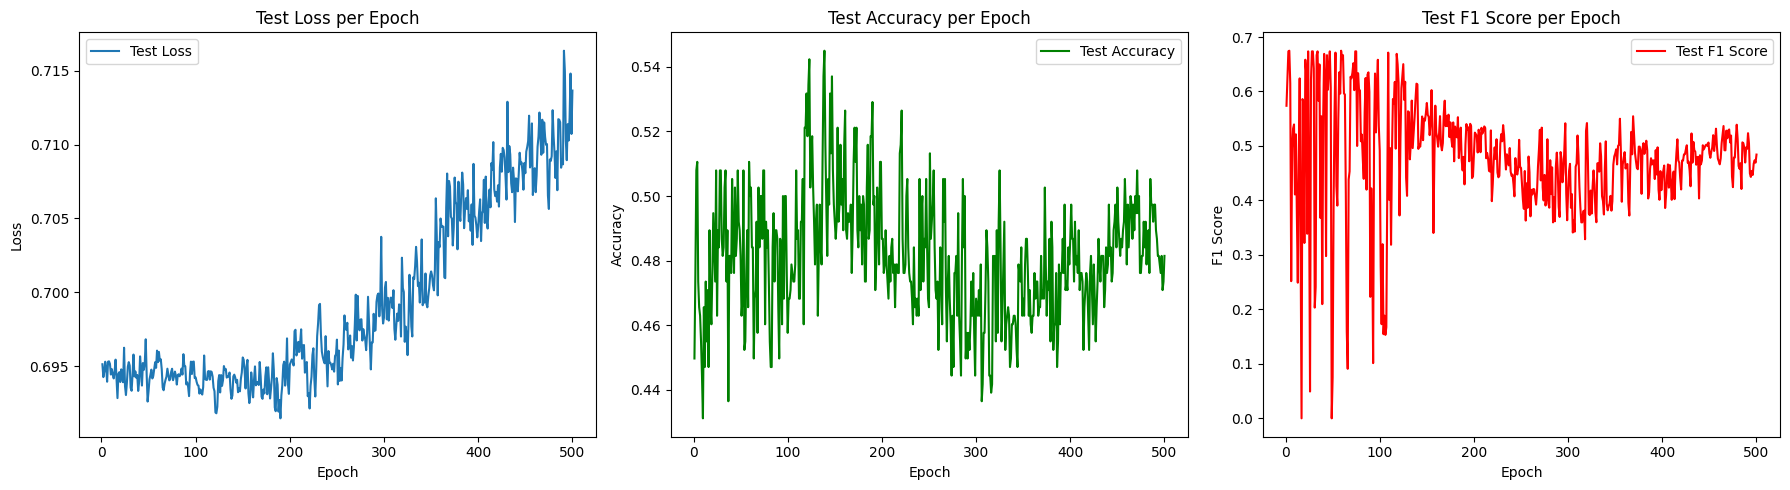

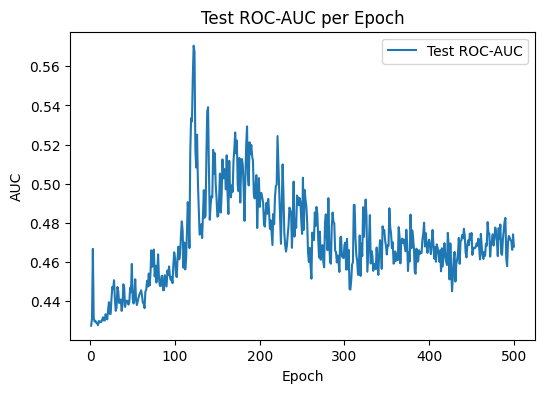


===== Final Evaluation on Test Set (Best Epoch) =====
Best Epoch: 122
Directional Accuracy (Accuracy): 0.5344
F1 Score: 0.5138
ROC-AUC: 0.5705
Test Loss: 0.6918
Predicted 1's proportion: 44.97%

===== Confusion Matrix (rows=true, cols=pred) =====
[[109  77]
 [ 99  93]]


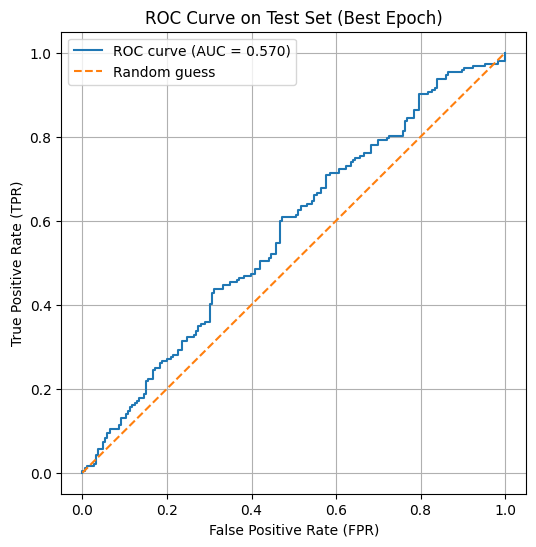

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# metrics & plotting
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

# to run on colab
from google.colab import drive
import matplotlib.pyplot as plt

# -----------------------------
# 1. Choose mode
# -----------------------------
FEATURE_MODE = "sentiment"   # 'sentiment'(method 1) / 'market' / 'both'(method 2)

# -----------------------------
# 2. Read sentiment + DJIA, and merge by date
# -----------------------------
try:
    drive.mount('/content/drive', force_remount=True)

    # sentiment data
    sent_path = "/content/drive/MyDrive/Colab Notebooks/COMP576/news_label_daily_sentiment_scores.csv"
    df_sent = pd.read_csv(sent_path)

    # DJIA data
    djia_path = "/content/drive/MyDrive/Colab Notebooks/COMP576/upload_DJIA_table.csv"
    df_djia = pd.read_csv(djia_path)

    df_sent["Date"] = pd.to_datetime(df_sent["Date"])
    df_djia["Date"] = pd.to_datetime(df_djia["Date"])
    df = pd.merge(df_sent, df_djia, on="Date", how="inner").sort_values("Date").reset_index(drop=True)  # merge only when dates match
    print(df[["Date", "sentiment_score", "Close"]].head())
    print(df[["Date", "sentiment_score", "Close"]].tail())

except Exception as e:
    print("Drive mount failed or file not found. Please check paths.")
    raise e

print("Number of data：", len(df))
print("Range of date：", df["Date"].min(), "~", df["Date"].max())

# -----------------------------
# 3. Model configuration
# -----------------------------
batch_size = 64
test_batch_size = 100
epochs = 500
lr = 0.0003
try_cuda = True
sinseed = 1000
HIDDEN_SIZE = 64
window_size = 5           # sliding window size

if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.manual_seed(sinseed)
else:
    cuda = False
    torch.manual_seed(sinseed)

device = torch.device("cuda" if cuda else "cpu")
print("Device:", device)

# -----------------------------
# 4. Choose input data
# -----------------------------
possible_market_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
market_cols = [c for c in possible_market_cols if c in df.columns]

if FEATURE_MODE == "sentiment":
    feature_cols = ["sentiment_score"]
elif FEATURE_MODE == "market":
    if len(market_cols) == 0:
        raise ValueError("Can't find [Open/High/Low/Close/Volume...], check upload_DJIA_table.csv")
    feature_cols = market_cols
elif FEATURE_MODE == "both":
    if len(market_cols) == 0:
        raise ValueError("Can't find [Open/High/Low/Close/Volume...], check upload_DJIA_table.csv")
    feature_cols = ["sentiment_score"] + market_cols
else:
    raise ValueError("FEATURE_MODE has to be one of 'sentiment' / 'market' / 'both'")

print("Feature columns:", feature_cols)

raw_features = df[feature_cols].values.astype(np.float32)  # (N, feature_dim)
Labels = df["Label"].values.astype(np.int64)
Dates  = df["Date"].values

# -----------------------------
# 5. Separate train / test and use train-only fit scaler
# -----------------------------
split_date = pd.Timestamp("2014-12-31")

train_mask = (df["Date"] <= split_date).values
if not train_mask.any():
    raise ValueError("No date in data <= 2014-12-31")

split_idx = np.where(train_mask)[0].max()
print("Last Day index for training =", split_idx, "Date =", df.loc[split_idx, "Date"])

# fit scaler with train data to avoid data leakage
scaler = StandardScaler()
scaler.fit(raw_features[:split_idx + 1])
Features = scaler.transform(raw_features)

feature_dim = Features.shape[1]
INPUT_SIZE = feature_dim
print("feature_dim =", feature_dim)

# -----------------------------
# 6. Sliding window
# -----------------------------
past_train, labels_train = [], []
past_test, labels_test   = [], []

N = len(df)

# train: window ends at split_idx
for t in range(window_size, split_idx + 1):
    past_train.append(Features[t - window_size:t, :])
    labels_train.append(Labels[t])

# test: label index > split_idx
for t in range(split_idx + 1, N):
    if t - window_size < 0:
        continue
    past_test.append(Features[t - window_size:t, :])
    labels_test.append(Labels[t])

past_train = np.array(past_train, dtype=np.float32)
labels_train = np.array(labels_train, dtype=np.int64)
past_test = np.array(past_test, dtype=np.float32)
labels_test = np.array(labels_test, dtype=np.int64)

print("Train X shape:", past_train.shape)
print("Train y shape:", labels_train.shape)
print("Test  X shape:", past_test.shape)
print("Test  y shape:", labels_test.shape)

train_dataset = TensorDataset(torch.from_numpy(past_train), torch.from_numpy(labels_train))
test_dataset  = TensorDataset(torch.from_numpy(past_test),  torch.from_numpy(labels_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# -----------------------------
# 7. 建立模型
# -----------------------------
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.GRU(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=2,
            batch_first=True
        )
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(HIDDEN_SIZE, 2)

    def forward(self, x):
        r_out, h_n = self.rnn(x)
        last_hidden = r_out[:, -1, :]
        dropped_out = self.dropout(last_hidden)
        logits = self.out(dropped_out)
        return logits

model = Net().to(device)

# -----------------------------
# 8. class weights, loss, optimizer
# -----------------------------
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# -----------------------------
# 9. train & test
# -----------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).long()

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    return running_loss / len(loader.dataset)

def test(model, loader, device, criterion=None, return_details=False):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).long()
            logits = model(X_batch)
            probs = torch.softmax(logits, dim=1)[:, 1]  # probability of class 1

            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

            if criterion is not None:
                loss = criterion(logits, y_batch)
                total_loss += loss.item() * X_batch.size(0)

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    prop_ones = np.mean(all_preds)
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds)
    avg_loss = total_loss / len(loader.dataset) if criterion is not None else 0.0

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except Exception:
        auc = float("nan")

    if return_details:
        return acc, f1, prop_ones, avg_loss, auc, all_preds, all_labels, all_probs
    else:
        return acc, f1, prop_ones, avg_loss, auc

# -----------------------------
# 10. training loop
# ### Select epoch with highest AUC as the benchmark(best epoch)
# -----------------------------
print(f"{'Epoch':^5} | {'Loss':^8} | {'TrnAcc':^8} | {'Trn1s%':^8} | {'TstAcc':^8} | {'TstF1':^8} | {'TstAUC':^8} | {'TstLoss':^8} | {'Tst1s%':^8}")
print("-"*110)

# for plotting line charts
test_loss_hist = []
test_acc_hist  = []
test_f1_hist   = []
test_auc_hist  = []

best_test_auc = -np.inf
best_epoch = None
best_state_dict = None      # store best epoch model's parameters

for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    train_acc, train_f1, train_prop, train_eval_loss, train_auc = test(model, train_loader, device, criterion)
    test_acc,  test_f1,  test_prop,  test_loss,  test_auc  = test(model, test_loader,  device, criterion)

    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)
    test_f1_hist.append(test_f1)
    test_auc_hist.append(test_auc)

    # select best epoch
    if not np.isnan(test_auc) and test_auc > best_test_auc:
        best_test_auc = test_auc
        best_epoch = epoch
        best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(
        f"{epoch:02d}    | "
        f"{train_loss:.4f}   | "
        f"{train_acc:.4f}   | "
        f"{train_prop:.2%}   | "
        f"{test_acc:.4f}   | "
        f"{test_f1:.4f}   | "
        f"{(test_auc if not np.isnan(test_auc) else 0):.4f}   | "
        f"{test_loss:.4f}   | "
        f"{test_prop:.2%}"
    )

print(f"\n>>> Best epoch by Test AUC: {best_epoch}  (AUC = {best_test_auc:.4f})")

# change model weight to the best epoch version
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    model.to(device)

# -----------------------------
# 11. Draw line charts: Test Loss / Test Acc / Test F1 / Test AUC
# -----------------------------
epochs_range = range(1, len(test_loss_hist) + 1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test Loss per Epoch")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, test_acc_hist, label="Test Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy per Epoch")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, test_f1_hist, label="Test F1 Score", color="red")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Test F1 Score per Epoch")
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, test_auc_hist, label="Test ROC-AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Test ROC-AUC per Epoch")
plt.legend()
plt.show()

# -----------------------------
# 12. Last test(with best epoch's model): Directional Accuracy / ROC-AUC / Confusion Matrix / Baseline
# -----------------------------
final_acc, final_f1, final_prop, final_loss, final_auc, final_preds, final_labels, final_probs = \
    test(model, test_loader, device, criterion, return_details=True)

print("\n===== Final Evaluation on Test Set (Best Epoch) =====")
print(f"Best Epoch: {best_epoch}")
print(f"Directional Accuracy (Accuracy): {final_acc:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"ROC-AUC: {final_auc:.4f}")
print(f"Test Loss: {final_loss:.4f}")
print(f"Predicted 1's proportion: {final_prop:.2%}")

# Confusion Matrix
cm = confusion_matrix(final_labels, final_preds)
print("\n===== Confusion Matrix (rows=true, cols=pred) =====")
print(cm)

# -----------------------------
# 13. Draw ROC Curve(with best epoch's model)
# -----------------------------
fpr, tpr, thresholds = roc_curve(final_labels, final_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {final_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Test Set (Best Epoch)")
plt.legend()
plt.grid(True)
plt.show()